In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import torch

In [3]:
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

In [26]:
from fcapy.visualizer import LineVizNx
import matplotlib.pyplot as plt

plt.rcParams['figure.facecolor'] = (1,1,1,1)

import neural_lib as nl

In [4]:
from fcapy.context import FormalContext
from fcapy.lattice import ConceptLattice

In [5]:
from scipy.stats import uniform, randint

from sklearn.datasets import load_breast_cancer, load_diabetes, load_wine
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, roc_auc_score, recall_score
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer

import xgboost as xgb

In [6]:
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score

In [7]:
PATH = 'C:\\Users\\Ayub\\Downloads\\datasets\\uci_malware_detection.csv'
df = pd.read_csv(PATH)

In [8]:
df = df.drop_duplicates()

In [9]:
y = df['Label']
X = df.drop(['Label'],axis=1)

In [10]:
# binarize
y = y.apply(lambda x: 0 if x=='malicious' else 1)

In [11]:
X.index = [str(id) for id in list(X.index)]

In [12]:
cols = X.columns
for col in cols:
        X[col] = X[col].apply(lambda x : False if (x==0 or x == '0') else True)

In [13]:
for col in X.columns:
    if len(X[col].value_counts()) <= 1:
        X.drop([col], axis=1, inplace=True)

In [14]:
#Feature selection based on decision tree

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [16]:
features = {}
cols = X_train.columns
for i in range(len(cols)):
    features[f'f{i}'] = cols[i]

Feature ranking:
1. F_20 0.048611 
2. F_141 0.048350 
3. F_67 0.045452 
4. F_21 0.044285 
5. F_140 0.037497 
6. F_68 0.036441 
7. F_163 0.030079 
8. F_52 0.028863 
9. F_386 0.025433 
10. F_112 0.024362 
11. F_114 0.022885 
12. F_267 0.021329 
13. F_70 0.020564 
14. F_180 0.019653 
15. F_319 0.018798 
16. F_51 0.018126 
17. F_50 0.017198 
18. F_279 0.017179 
19. F_317 0.016453 
20. F_292 0.016291 
21. F_335 0.016243 
22. F_321 0.016187 
23. F_363 0.014697 
24. F_187 0.013990 
25. F_436 0.012436 
26. F_183 0.011569 
27. F_30 0.010600 
28. F_56 0.010413 
29. F_53 0.009986 
30. F_33 0.009837 
31. F_400 0.009477 
32. F_404 0.009408 
33. F_423 0.008905 
34. F_291 0.008834 
35. F_185 0.008622 
36. F_324 0.008553 
37. F_208 0.008024 
38. F_54 0.007392 
39. F_48 0.007256 
40. F_419 0.007058 
41. F_23 0.006837 
42. F_315 0.006753 
43. F_190 0.006679 
44. F_498 0.005833 
45. F_40 0.005736 
46. F_31 0.005264 
47. F_476 0.005029 
48. F_401 0.004572 
49. F_130 0.004233 
50. F_147 0.004198 
51. F_353

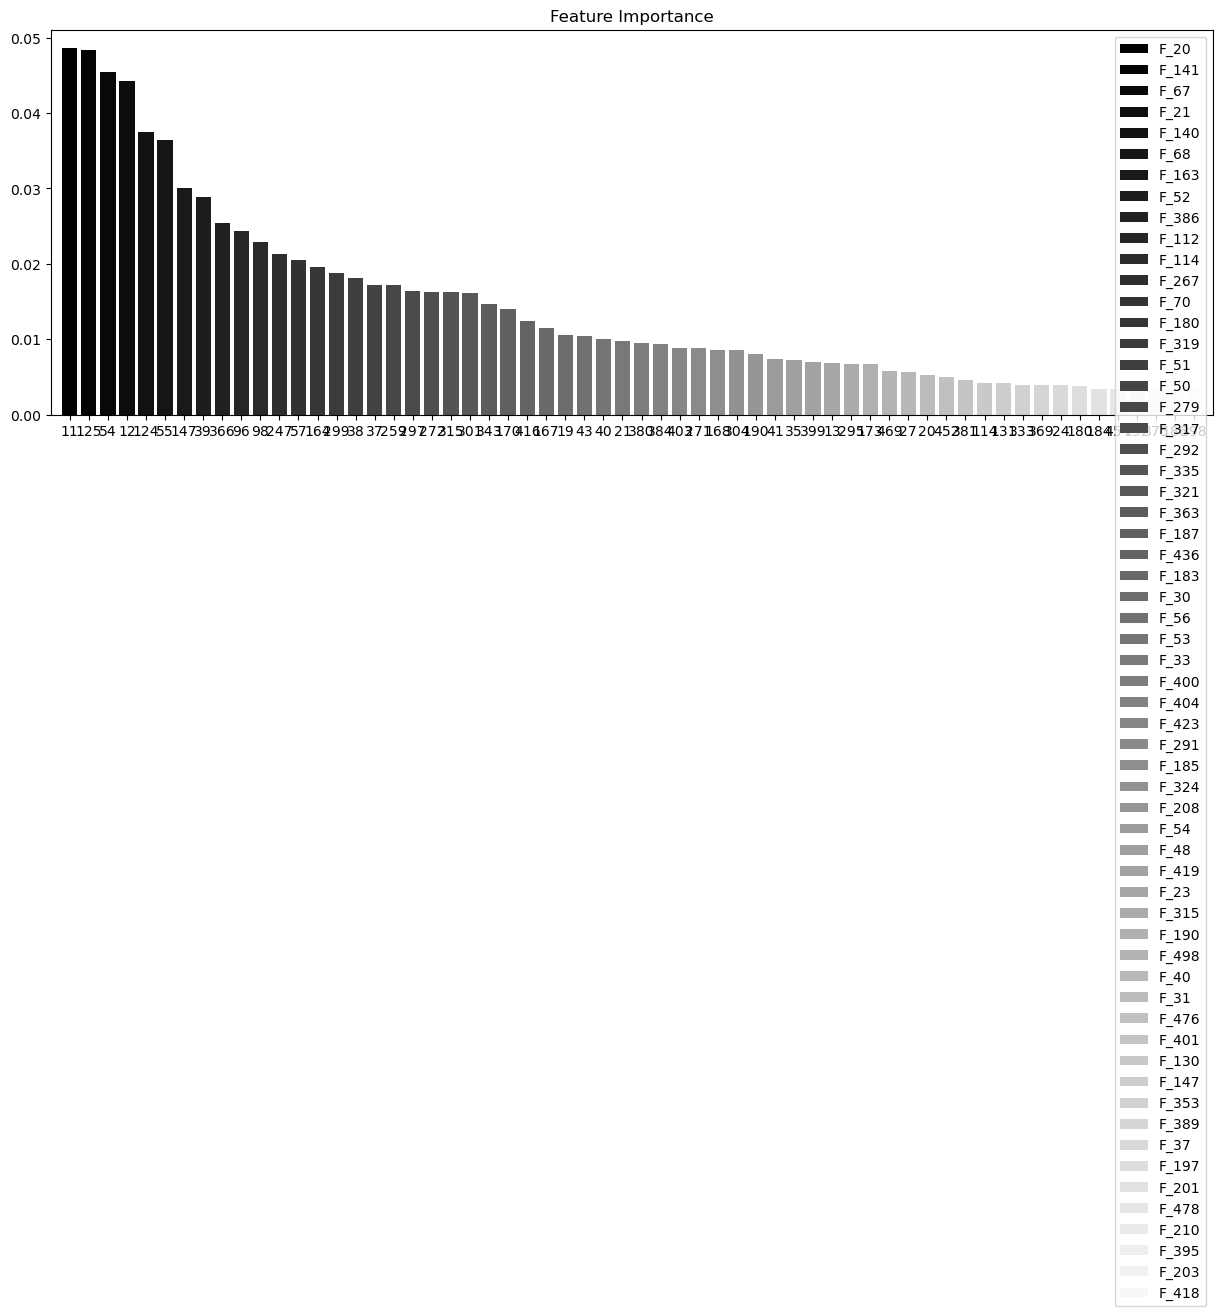

In [17]:
from sklearn.ensemble import RandomForestClassifier


forest = RandomForestClassifier(n_estimators=1000, random_state=0)

forest.fit(X_train, y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]
# Plot the feature importancies of the forest
num_to_plot = 60
feature_indices = [ind + 1 for ind in indices[:num_to_plot]]

# Print the feature ranking
print("Feature ranking:")

for f in range(num_to_plot):
    print(
        "%d. %s %f "
        % (f + 1, features["f" + str(feature_indices[f])], importances[indices[f]])
    )
plt.figure(figsize=(15, 5))
plt.title(u"Feature Importance")
bars = plt.bar(
    range(num_to_plot),
    importances[indices[:num_to_plot]],
    color=([str(i / float(num_to_plot + 1)) for i in range(num_to_plot)]),
    align="center",
)
ticks = plt.xticks(range(num_to_plot), feature_indices)
plt.xlim([-1, num_to_plot])
plt.legend(bars, [u"".join(features["f" + str(i)]) for i in feature_indices]);

In [18]:
best_60_feats = [features[f'f{i}'] for i in feature_indices]
best_60_feats;

In [19]:
X = X[best_60_feats]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [20]:
K_train = FormalContext.from_pandas(X_train)

In [21]:
L = ConceptLattice.from_context(K_train, is_monotone=True, algo='Sofia')

In [22]:
from sklearn.metrics import f1_score

for c in L:
    y_preds = np.zeros(K_train.n_objects)
    y_preds[list(c.extent_i)] = 1
    c.measures['f1_score'] = f1_score(y_train, y_preds)

In [23]:
best_concepts = list(L.measures['f1_score'].argsort()[::-1][:8])

len({g_i for c in L[best_concepts] for g_i in c.extent_i})#==K_train.n_objects


57

In [24]:
L.measures['f1_score']

array([0.        , 0.07017544, 0.25396825, 0.28125   , 0.33333333,
       0.38235294, 0.45070423, 0.53333333, 0.55263158, 0.57142857,
       0.60759494, 0.625     , 0.625     , 0.64197531, 0.65853659,
       0.65853659, 0.6746988 , 0.6746988 , 0.6746988 , 0.69047619,
       0.72093023, 0.72093023, 0.72093023, 0.72093023, 0.73563218,
       0.73563218, 0.73563218, 0.75      , 0.76404494, 0.76404494,
       0.77777778, 0.77777778, 0.79120879, 0.8172043 , 0.8172043 ,
       0.8172043 , 0.82978723, 0.82978723, 0.84210526, 0.84210526,
       0.85416667, 0.85416667, 0.87755102, 0.87755102, 0.87755102,
       0.87755102, 0.88888889, 0.88888889, 0.93203883, 0.94230769,
       0.95238095, 0.98214286, 0.49773756, 0.36123348, 0.40343348,
       0.40343348, 0.44351464, 0.4526749 , 0.19354839, 0.39426523,
       0.21908127, 0.21908127, 0.23776224, 0.24390244, 0.24390244,
       0.26206897, 0.26206897, 0.35172414, 0.26804124, 0.26804124,
       0.27986348, 0.37414966, 0.29152542, 0.29152542, 0.29152

In [27]:
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))

In [28]:
vis = LineVizNx(node_label_font_size=6, node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes))+'\n\n')

In [29]:
descr = {'F_20', 'F_21', 'F_50', 'F_324'}

traced = cn.trace_description(descr, include_targets=False)

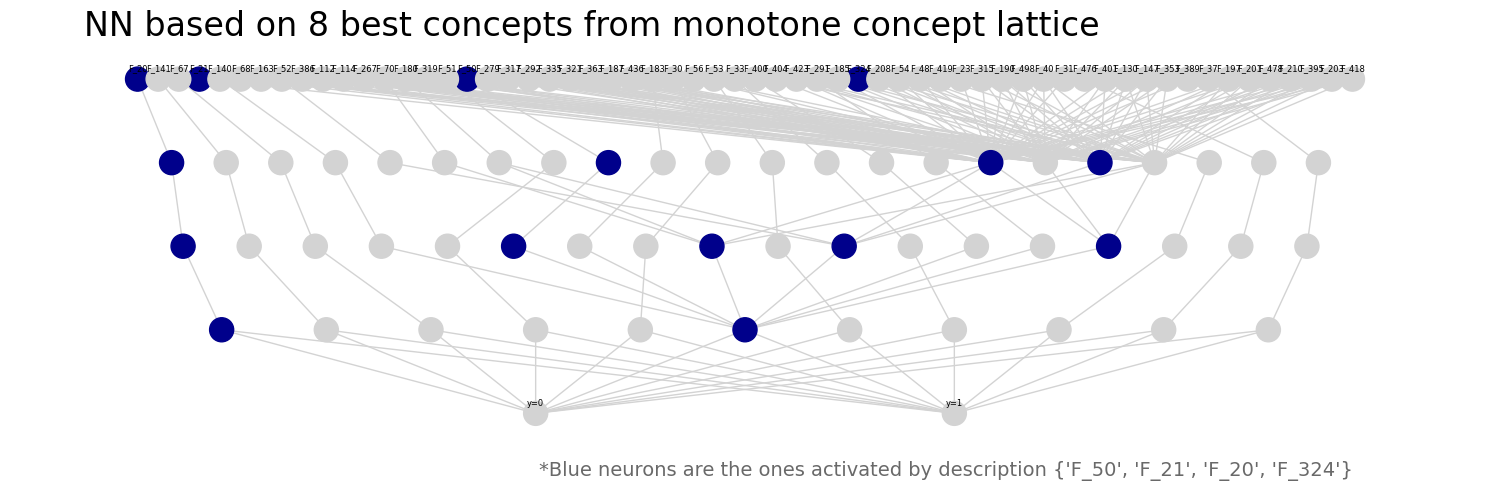

In [30]:
fig, ax = plt.subplots(figsize=(15,5))

vis.draw_poset(
    cn.poset, ax=ax,
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    node_color=['darkblue' if el_i in traced else 'lightgray' for el_i in range(len(cn.poset))]
)
plt.title(f'NN based on 8 best concepts from monotone concept lattice', loc='left', x=0.05, size=24)

plt.text(max(vis.mover.posx), min(vis.mover.posy)-0.3, f'*Blue neurons are the ones activated by description {descr}', fontsize=14, ha='right', color='dimgray')

plt.subplots_adjust()
plt.tight_layout()
plt.show()

In [31]:
cn.fit(X_train, y_train)

In [32]:
print('Class prediction', cn.predict(X_test).numpy())
print('Class prediction with probabilities', cn.predict_proba(X_test).detach().numpy())
print('True class', y_test.values)

Class prediction [0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0
 0]
Class prediction with probabilities [[9.9923849e-01 7.6148834e-04]
 [9.9923849e-01 7.6148834e-04]
 [9.9923849e-01 7.6148834e-04]
 [9.9923849e-01 7.6148834e-04]
 [9.9923849e-01 7.6148834e-04]
 [9.9923849e-01 7.6148834e-04]
 [9.9923849e-01 7.6148834e-04]
 [9.9923849e-01 7.6148834e-04]
 [3.5201504e-03 9.9647993e-01]
 [9.9923849e-01 7.6148834e-04]
 [9.9923849e-01 7.6148834e-04]
 [9.9923849e-01 7.6148834e-04]
 [9.9923849e-01 7.6148834e-04]
 [3.5201504e-03 9.9647993e-01]
 [9.9923849e-01 7.6148834e-04]
 [9.9923849e-01 7.6148834e-04]
 [9.9923849e-01 7.6148834e-04]
 [3.5201504e-03 9.9647993e-01]
 [9.9923849e-01 7.6148834e-04]
 [9.9923849e-01 7.6148834e-04]
 [9.9923849e-01 7.6148834e-04]
 [9.9923849e-01 7.6148834e-04]
 [3.5201504e-03 9.9647993e-01]
 [3.5

In [33]:
f1_score(cn.predict(X_test).numpy(), y_test)

1.0

In [34]:
##Compare with XGboost on the same set of attributes
xgb_model = xgb.XGBClassifier(objective="binary:logistic", enable_categorical=True, random_state=42)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print('f1_score is ', f1_score(y_test, y_pred))

[[97  0]
 [ 0 15]]
f1_score is  1.0


In [35]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=1000, random_state=0)

forest.fit(X_train, y_train)

y_preds = forest.predict(X_test)
print('f1_score is ', f1_score(y_test, y_preds))

f1_score is  1.0


In [36]:
edge_weights = cn.edge_weights_from_network()

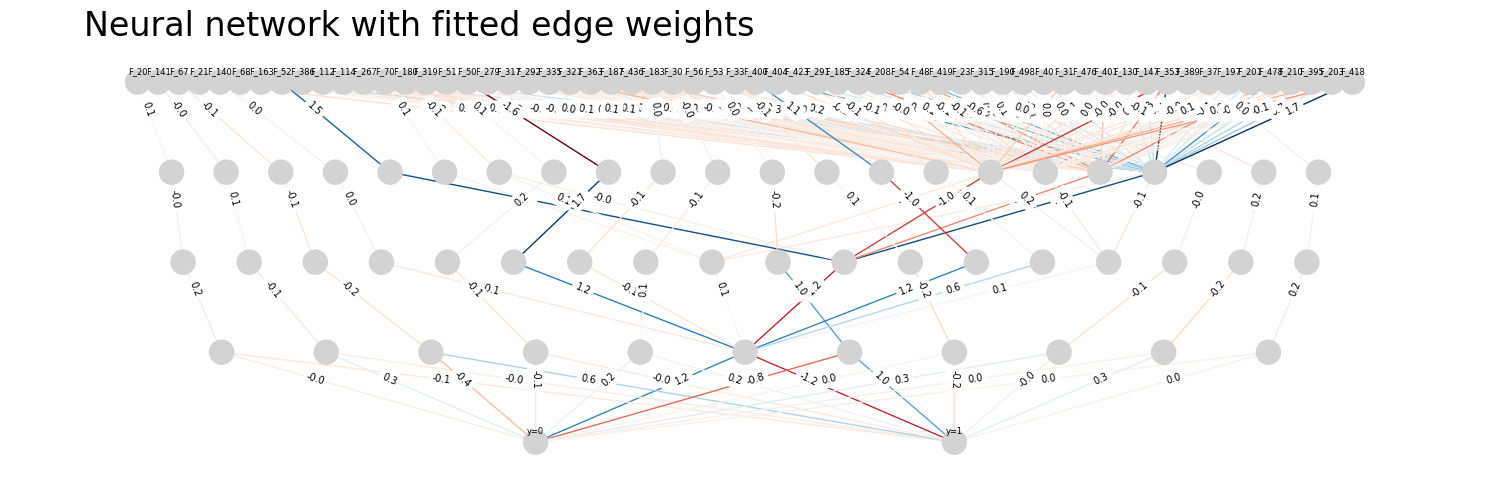

In [37]:
import networkx as nx

fig, ax = plt.subplots(figsize=(15,5))

vis.draw_poset(
    cn.poset, ax=ax,
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    edge_color=[edge_weights[edge] for edge in cn.poset.to_networkx().edges],
    edge_cmap=plt.cm.RdBu,
)
nx.draw_networkx_edge_labels(cn.poset.to_networkx(), vis.mover.pos, {k: f"{v:.1f}" for k,v in edge_weights.items()}, label_pos=0.7, font_size=7)

plt.title('Neural network with fitted edge weights', size=24, x=0.05, loc='left')
plt.tight_layout()
plt.subplots_adjust()
plt.savefig('fitted_network.png')
plt.show()